In [5]:
!pip install ultralytics opencv-python

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from google.colab import files

In [7]:
# Load YOLOv8 Large model pretrained on COCO
model = YOLO("yolov8l.pt")

# -------- Step 2: Upload an Image --------
print("📤 Please upload a road scene image...")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

frame = cv2.imread(image_path)
if frame is None:
    raise Exception("❌ Image not found! Check your upload.")


📤 Please upload a road scene image...


Saving Gemini_Generated_Image_p5iu0pp5iu0pp5iu.png to Gemini_Generated_Image_p5iu0pp5iu0pp5iu (1).png


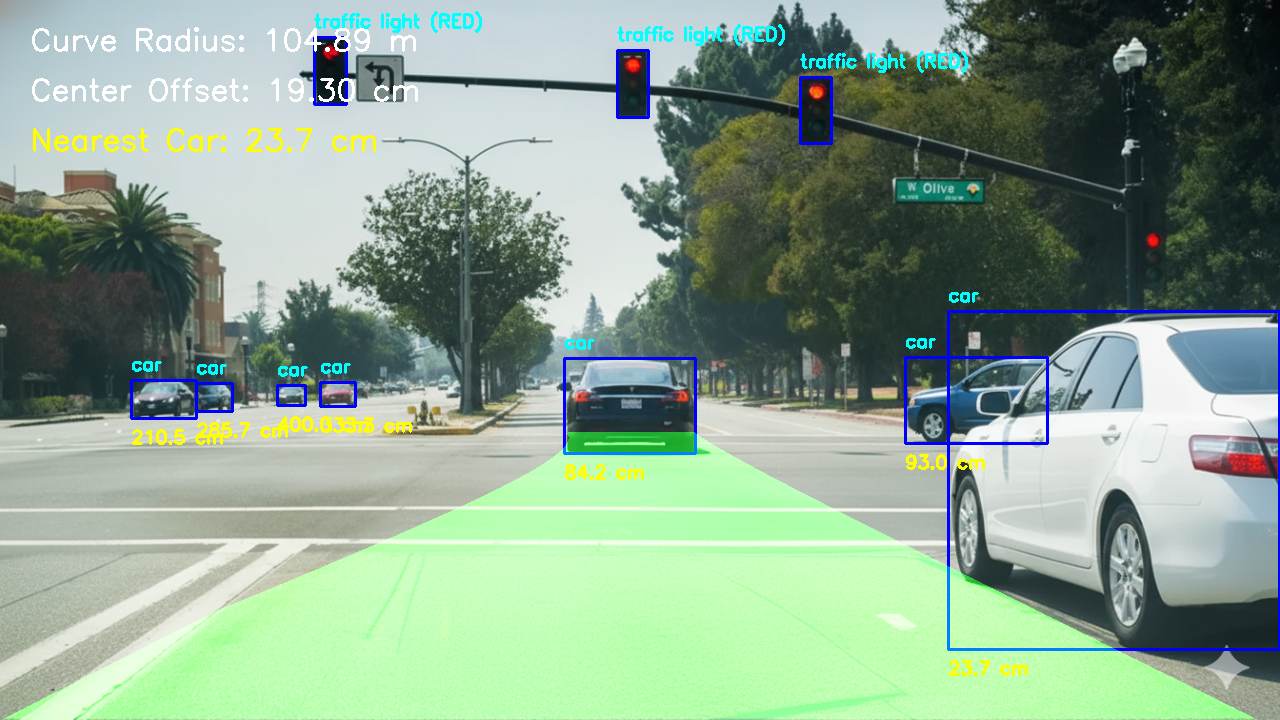

In [8]:
# Resize for faster inference
frame = cv2.resize(frame, (1280, 720))
h, w, _ = frame.shape


# -------- Step 4: Advanced Lane Detection Function --------
def detect_lane(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    # Region of interest (bottom half)
    mask = np.zeros_like(edges)
    polygon = np.array([[
        (0, h),
        (w, h),
        (w, int(h * 0.6)),
        (0, int(h * 0.6))
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    cropped = cv2.bitwise_and(edges, mask)

    # Perspective transform (bird’s eye view)
    src = np.float32([[200, h], [w-200, h], [w//2+50, int(h*0.6)], [w//2-50, int(h*0.6)]])
    dst = np.float32([[200, h], [w-200, h], [w-200, 0], [200, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(cropped, M, (w, h))

    # Histogram to find lane base positions
    histogram = np.sum(warped[warped.shape[0]//2:, :], axis=0)
    midpoint = np.int32(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Sliding window lane detection
    nwindows = 9
    window_height = np.int32(h // nwindows)
    nonzero = warped.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    leftx_current, rightx_current = leftx_base, rightx_base
    margin, minpix = 100, 50
    left_lane_inds, right_lane_inds = [], []

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low, win_xleft_high = leftx_current - margin, leftx_current + margin
        win_xright_low, win_xright_high = rightx_current - margin, rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds]
    rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]

    if len(leftx) == 0 or len(rightx) == 0:
        return frame  # No lanes found

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, h - 1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fill the lane area
    lane_area = np.zeros_like(warped).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(lane_area, np.int_([pts]), 255)

    # Warp lane area back to original
    Minv = cv2.getPerspectiveTransform(dst, src)
    lane_unwarped = cv2.warpPerspective(lane_area, Minv, (w, h))
    lane_colored = np.zeros_like(frame)
    lane_colored[:, :, 1] = lane_unwarped  # Green fill

    # Combine
    result = cv2.addWeighted(frame, 1, lane_colored, 0.5, 0)

    # Calculate curvature & center offset
    ym_per_pix, xm_per_pix = 30/720, 3.7/700
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    car_center = w / 2
    center_offset = (car_center - lane_center) * xm_per_pix * 100

    cv2.putText(result, f"Curve Radius: {curvature:.2f} m", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, f"Center Offset: {center_offset:.2f} cm", (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    return result


# -------- Step 5: Traffic Light Color Detection --------
def detect_traffic_light_color(roi):
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    red1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
    red2 = cv2.inRange(hsv, (160, 100, 100), (179, 255, 255))
    red = cv2.bitwise_or(red1, red2)
    yellow = cv2.inRange(hsv, (15, 100, 100), (35, 255, 255))
    green = cv2.inRange(hsv, (40, 50, 50), (90, 255, 255))
    counts = {"RED": cv2.countNonZero(red), "YELLOW": cv2.countNonZero(yellow), "GREEN": cv2.countNonZero(green)}
    color = max(counts, key=counts.get)
    if counts[color] < 50:
        return "UNKNOWN"
    return color


# -------- Step 6: YOLO Object Detection --------
results = model.predict(source=frame, conf=0.6, iou=0.45, verbose=False)

distances = []  # store estimated distances of cars
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        color_state = ""
        if label == "traffic light":
            roi = frame[y1:y2, x1:x2]
            if roi.size != 0:
                color_state = detect_traffic_light_color(roi)

        if label == "car":
            # Approximate distance using height of bounding box
            car_height = y2 - y1
            if car_height > 0:
                distance = 8000 / car_height  # simplified distance estimate
                distances.append((distance, (x1, y1)))
                cv2.putText(frame, f"{distance:.1f} cm", (x1, y2 + 25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        label_text = f"{label}"
        if color_state:
            label_text += f" ({color_state})"
        cv2.putText(frame, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

# Highlight nearest car
if distances:
    nearest = min(distances, key=lambda x: x[0])
    cv2.putText(frame, f"Nearest Car: {nearest[0]:.1f} cm", (30, 150),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

# -------- Step 7: Add Lane Visualization --------
output = detect_lane(frame)

# -------- Step 8: Display Final Output --------
cv2_imshow(output)